##### Mamy co prawda dodatkowe benefity dla naszych najlepszych klientów, ale może dałobysię ustalić kto potencjalnie jest skłonny wydawać u nas więcej?

# Etap 1

1. Definicja problemu biznesowego, zdefiniowanie zadania/zadań modelowania i wszystkich założeń, zaproponowanie kryteriów sukcesu.
2. Analiza danych z perspektywy realizacji tych zadań (trzeba ocenić, czy dostarczone dane są wystarczające – może czegoś brakuje, może coś trzeba poprawić, domagać się innych danych).

#### Kontekst
- sklep internetowy z elektroniką i grami komputerowymi.

#### Zadanie biznesowe
- przewidywanie czy dana sesja klienta zakończy się zakupem po zaoferowaniu mu odpowiedniej zniżki

#### Biznesowe kryterium sukcesu
- Po wdrożeniu systemu oczekujemy, że sprzedaż wzrośnie. Model przewiduje, czy dana sesja skończy się zakupem. Po ponownym uruchomieniu modelu, ale ze zwiększoną zniżką znajdziemy klientów, którzy po zmianie ceny jednak zdecydują się na zakup, dlatego dzięki modelowi więcej osób będzie kupować produkty.

#### Definicja zadania/zadań modelowania

- ##### Zadanie modelowania: 
    klasyfikacja (Logistic Regression i XGBoost)

- ##### Dane do modelowania
    Zbiór danych sesji uzupełnionych o ceny, kategorie produktów oraz miasto zamieszkania usera.
    - users: id, city
    - sessions: session_id, user_id, timestamp, product_id, **event_type, offered_discount**, purchase_id
    - product_id, category_path, **price**
    
Finalna decyzja zakupu może mieć duży związek z interakcją ceny z obniżką. Klient może być bardziej skory do kupna, jeżeli dostanie 10% zniżki na produkt o wartości 1000 zł, niż do kupna produktu z tą samą zniżką, ale o wartości 100 zł. 

- ##### Analityczne kryterium sukcesu
Zbudowanie zbalansowanego modelu, który przewyższa wskaźnik F1 modelu naiwnego.

_Model naiwny w naszym przypadku mógłby przewidywać tylko VIEW PRODUCT i miałby wtedy około 85,7% skuteczności (Aktualnie na 6 akcji VIEW PRODUCT, mamy 1 akcję BUY PRODUCT (14.3%)), ale jego wskaźnik F1 wynosi 0. Celem jest zbudowanie modelu, którego wskaźnik F1 jest wyższy._

#### Założenia
- przewidujemy klasę dla danych wejściowych (event type: VIEW PRODUCT lub BUY PRODUCT)
- parametry analitycznego kryterium sukcesu są ustalone bezpośrednio na podstawie biznesowego kryterium sukcesu.

#### Analiza danych z perspektywy realizacji zadań

Pracujemy na nowych danych, które nie zawierają braków.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
import os, glob

inputs = []

for each in sorted(glob.glob(os.path.join(os.getcwd(),'./new_data/*.jsonl'), recursive=True)):
    print(f'Name with path: {each} \nName without path: {os.path.basename(each)}')
    inputs.append(each)

Name with path: C:\Users\Bindas\PycharmProjects\flaskProject\./new_data\deliveries.jsonl 
Name without path: deliveries.jsonl
Name with path: C:\Users\Bindas\PycharmProjects\flaskProject\./new_data\products.jsonl 
Name without path: products.jsonl
Name with path: C:\Users\Bindas\PycharmProjects\flaskProject\./new_data\sessions.jsonl 
Name without path: sessions.jsonl
Name with path: C:\Users\Bindas\PycharmProjects\flaskProject\./new_data\users.jsonl 
Name without path: users.jsonl


In [4]:
deliveries = pd.read_json(inputs[0], lines=True)
products = pd.read_json(inputs[1], lines=True)
sessions = pd.read_json(inputs[2], lines=True)
users = pd.read_json(inputs[3], lines=True)

USERS

In [5]:
users.count()

user_id    200
name       200
city       200
street     200
dtype: int64

In [6]:
users.sample(3)

,user_id,name,city,street
72,174,Witold Gietka,Warszawa,pl. Słowicza 351
105,207,Albert Leszczyk,Mielec,al. Słowicza 77
23,125,Borys Doroba,Warszawa,ul. Witosa 58


In [7]:
# nie ma dwóch użytkowników o takich samych imionach i nazwiskach
users.name.nunique()

200

DELIVERIES

In [8]:
deliveries.count()

purchase_id           6339
purchase_timestamp    6339
delivery_timestamp    6339
delivery_company      6339
dtype: int64

In [9]:
deliveries.sample(3)

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
3953,23954,2021-02-21T12:49:24,2021-02-25T12:52:28,620
3439,23440,2020-11-29T04:00:01,2020-12-04T04:04:07,620
4464,24465,2021-02-09T12:06:15,2021-02-11T12:06:40,620


In [10]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   purchase_id         6339 non-null   int64 
 1   purchase_timestamp  6339 non-null   object
 2   delivery_timestamp  6339 non-null   object
 3   delivery_company    6339 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 198.2+ KB


In [11]:
pd.DataFrame({'total_missing': deliveries.isnull().sum(), 'perc_missing': (deliveries.isnull().sum()/deliveries.purchase_id.count())*100})

,total_missing,perc_missing
purchase_id,0,0.0
purchase_timestamp,0,0.0
delivery_timestamp,0,0.0
delivery_company,0,0.0


SESSIONS

In [12]:
sessions.describe()

,session_id,user_id,product_id,offered_discount,purchase_id
count,37169.000000,37169.000000,37169.000000,37169.000000,6339.00000
mean,104916.144421,201.799645,1126.983911,4.875434,23170.00000
std,2833.445266,57.784774,118.472731,6.986422,1830.05601
min,100001.000000,102.000000,1001.000000,0.000000,20001.00000
25%,102467.000000,151.000000,1036.000000,0.000000,21585.50000
50%,104891.000000,198.000000,1067.000000,0.000000,23170.00000
75%,107403.000000,252.000000,1278.000000,10.000000,24754.50000
max,109837.000000,301.000000,1319.000000,20.000000,26339.00000


In [13]:
sessions.sample(3)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
5047,101363,2020-07-27 05:30:57,132,1051,VIEW_PRODUCT,15,NaN
34795,109213,2021-02-13 11:23:04,289,1290,VIEW_PRODUCT,0,NaN
3148,100871,2021-04-11 14:18:33,121,1008,VIEW_PRODUCT,20,NaN


In [14]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37169 entries, 0 to 37168
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        37169 non-null  int64         
 1   timestamp         37169 non-null  datetime64[ns]
 2   user_id           37169 non-null  int64         
 3   product_id        37169 non-null  int64         
 4   event_type        37169 non-null  object        
 5   offered_discount  37169 non-null  int64         
 6   purchase_id       6339 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.0+ MB


In [15]:
pd.DataFrame({'total_missing': sessions.isnull().sum(), 'perc_missing': (sessions.isnull().sum()/sessions.session_id.count())*100})

,total_missing,perc_missing
session_id,0,0.000000
timestamp,0,0.000000
user_id,0,0.000000
product_id,0,0.000000
event_type,0,0.000000
offered_discount,0,0.000000
purchase_id,30830,82.945465


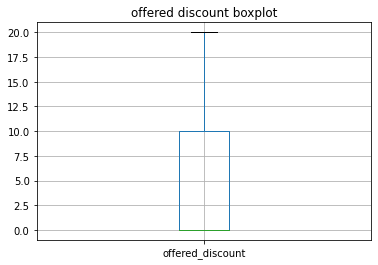

In [16]:
# nie ma żadnych wartości odstających do poprawienia
numerical_columns = ["offered_discount"]
sessions[numerical_columns].boxplot()
plt.title("offered discount boxplot")
plt.show()

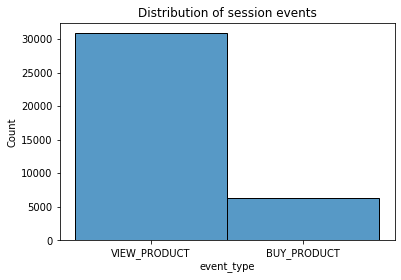

In [17]:
sns.histplot(sessions.event_type)
plt.title("Distribution of session events")
plt.show()

# na 6 oglądań, średnio mamy 1 zakup

In [18]:
# ile brakuje purchase_id gdy typ sesji to BUY_PRODUCT?
sessions[sessions.event_type=="BUY_PRODUCT"].purchase_id.isna().sum()

0

Gdy ktoś kupuje produkt, zawsze znamy id tego produktu.

In [19]:
# ile sesji typu VIEW_PRODUCT ma purchase_id (prawdopodobnie niepotrzebne informacje)?
sessions[sessions.event_type=="VIEW_PRODUCT"].purchase_id.notna().sum()

0

PRODUCTS

In [20]:
# brak pustych komóre
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


In [21]:
products.sample(3)

,product_id,product_name,category_path,price
155,1156,Rig&#39;n&#39;Roll Tirowiec (PC),Gry i konsole;Gry komputerowe,4.99
177,1178,King&#39;s Bounty Nowe Światy (PC),Gry i konsole;Gry komputerowe,9.99
124,1125,Diablo 3 (PC),Gry i konsole;Gry komputerowe,69.90


In [22]:
products.describe()

,product_id,price
count,319.000000,319.000000
mean,1160.000000,247.787962
std,92.231593,813.788548
min,1001.000000,1.000000
25%,1080.500000,24.990000
50%,1160.000000,41.000000
75%,1239.500000,92.995000
max,1319.000000,7639.000000


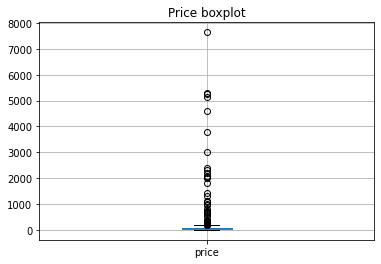

In [23]:
numerical_columns = ['price']
products[numerical_columns].boxplot()
plt.title('Price boxplot')
plt.show()

In [24]:
products[products['price'] == 1]

,product_id,product_name,category_path,price
140,1141,Król Futbolu Piłkarski Quiz (PC),Gry i konsole;Gry komputerowe,1.0
192,1193,Heroes Over Europe (PC),Gry i konsole;Gry komputerowe,1.0
271,1272,The Ball (PC),Gry i konsole;Gry komputerowe,1.0


In [25]:
# ceny niedodatnie
products[products['price'] <= 0].count()

product_id       0
product_name     0
category_path    0
price            0
dtype: int64

In [26]:
# merge sessions with products
shop_df = sessions.merge(products, on="product_id", how="left")

In [27]:
# merge sessions and products with users
shop_df = shop_df.merge(users, on='user_id', how = 'left')

In [28]:
shop_df.sample(3)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price,name,city,street
4775,101297,2020-10-24 06:35:00,131,1317,VIEW_PRODUCT,10,NaN,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1303.96,Cezary Armatys,Szczecin,ul. Chełmońskiego 059
12894,103406,2021-03-21 06:57:22,172,1008,VIEW_PRODUCT,0,NaN,Tom Clancy&#39;s Rainbow Six Vegas (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,Oskar Jaszczur,Gdynia,ul. Żurawia 50/80
590,100187,2021-03-18 22:58:48,105,1017,VIEW_PRODUCT,0,NaN,LCD Dell U2412M,Komputery;Monitory;Monitory LCD,399.00,Anastazja Oszust,Szczecin,ul. Częstochowska 80


In [29]:
shop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37169 entries, 0 to 37168
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        37169 non-null  int64         
 1   timestamp         37169 non-null  datetime64[ns]
 2   user_id           37169 non-null  int64         
 3   product_id        37169 non-null  int64         
 4   event_type        37169 non-null  object        
 5   offered_discount  37169 non-null  int64         
 6   purchase_id       6339 non-null   float64       
 7   product_name      37169 non-null  object        
 8   category_path     37169 non-null  object        
 9   price             37169 non-null  float64       
 10  name              37169 non-null  object        
 11  city              37169 non-null  object        
 12  street            37169 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 4.0+ MB


Zmienną celu jest event_type_BUY_PRODUCT. Sprawdzamy współczynnik wzajemnej informacji między tą zmienną i innymi atrybutami. 

Pomijamy atrybut purchase_id, ponieważ jest on znany tylko wtedy, gdy dokonano zakupu. Dodajemy kolumnę 'purchase_id_nan', której wartości to 1, gdy nie dokonano zakupu i 0, jeśli dokonano. 

Do analizy używamy one hot encoding (pd.get_dummies()) i dlatego pomijamy też kolumny 'name' oraz 'street'. Możemy to ominąć, ponieważ mamy kolumnę 'user_id', która mówi nam o tym, który to użytkownik. Z tego samego powodu pomijamy 'product_name' - mamy 'product_id' i to wystarczy.

In [30]:
shop_df["purchase_id_isnan"] = np.where(shop_df.purchase_id.isnull(), 1, 0)

# dodajemy nowy atrubut: price*offered_discount
shop_df["discount_price"] = (shop_df["price"] * shop_df["offered_discount"])

shop_df = shop_df[shop_df.columns[~shop_df.columns.isin(["session_id", "product_name", "purchase_id", "name", "street"])]]
shop_df = pd.get_dummies(shop_df)

## Sprawdzenie współczynnika wzajemnej informacji

In [31]:
shop_df_check = shop_df.copy()
shop_df_check.sample(3)

,timestamp,user_id,product_id,offered_discount,price,purchase_id_isnan,discount_price,event_type_BUY_PRODUCT,event_type_VIEW_PRODUCT,category_path_Gry i konsole;Gry komputerowe,...,category_path_Telefony i akcesoria;Telefony komórkowe,category_path_Telefony i akcesoria;Telefony stacjonarne,city_Gdynia,city_Konin,city_Kutno,city_Mielec,city_Police,city_Radom,city_Szczecin,city_Warszawa
8222,2021-03-06 17:30:10,146,1285,5,82.99,1,414.95,0,1,0,...,0,0,0,0,0,0,1,0,0,0
6575,2020-05-11 05:21:56,139,1044,20,79.90,1,1598.00,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4755,2020-04-18 21:33:44,131,1222,15,245.00,0,3675.00,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [32]:
shop_df_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37169 entries, 0 to 37168
Data columns (total 32 columns):
 #   Column                                                                           Non-Null Count  Dtype         
---  ------                                                                           --------------  -----         
 0   timestamp                                                                        37169 non-null  datetime64[ns]
 1   user_id                                                                          37169 non-null  int64         
 2   product_id                                                                       37169 non-null  int64         
 3   offered_discount                                                                 37169 non-null  int64         
 4   price                                                                            37169 non-null  float64       
 5   purchase_id_isnan                                                  

Sprawdzamy współczynnik wzajemnej informacji między zmienną celu, a innymi atrybutami. Aby sprawdzić, czy współczynnik jest wysoki, permutujemy każdą z kolumn tworząc szum i porównujemy wyniki wzajemnej informacji z szumem i z oryginalnym atrybutem.

In [33]:
y = shop_df_check["event_type_BUY_PRODUCT"]
shop_df_check = shop_df_check[shop_df_check.columns[~shop_df_check.columns.isin(["event_type_BUY_PRODUCT", "event_type_VIEW_PRODUCT", "purchase_id_isnan", "timestamp"])]]

# dataframe tylko dla XGB
shop_df_xgb = shop_df_check.copy()
y_xgb = y.copy()

cols = shop_df_check.columns
mutual_info_scores = {}
mutual_info_noise_scores = {}

shop_np_check = shop_df_check.to_numpy()
shop_np_check_with_noise = shop_df_check.copy().to_numpy()

mutual_info_scores = mutual_info_classif(shop_np_check, y)

# permutacja kolumn w shop_np_check_with_noise
np.random.seed(42)
np.random.shuffle(np.transpose(shop_np_check_with_noise))
mutual_info_noise_scores = mutual_info_classif(shop_np_check_with_noise, y)

In [34]:
mi_df = pd.DataFrame([mutual_info_scores, mutual_info_noise_scores], index=["mutual_info_score", "noise"]).T
mi_df.index = shop_df_check.columns
mi_df

,mutual_info_score,noise
user_id,0.010175,0.003115
product_id,0.029267,0.002629
offered_discount,0.000695,0.000000
price,0.023725,0.000000
discount_price,0.009080,0.007005
category_path_Gry i konsole;Gry komputerowe,0.000596,0.006129
category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,0.002988,0.002526
category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,0.004469,0.003207
category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,0.000800,0.004368
category_path_Komputery;Monitory;Monitory LCD,0.003823,0.000898


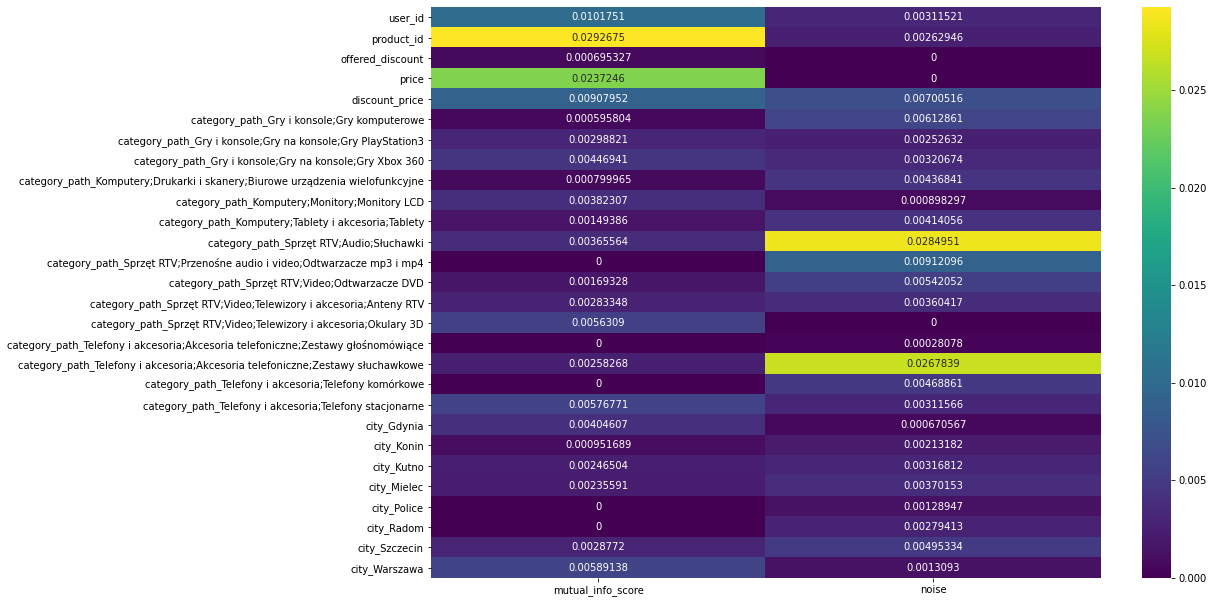

In [35]:
plt.figure(figsize=(15,10.5))
sns.heatmap(mi_df, annot=True, fmt="g", cmap='viridis')

plt.show()

Wybieramy kolumny, których współczynnik wzajemnej informacji z funkcją celu jest większy, niż funkcji celu z szumem.

In [36]:
useful_categories = np.where(mutual_info_scores > mutual_info_noise_scores, 1, 0)
useful_categories_indices = np.argwhere(useful_categories == np.amax(useful_categories))

In [37]:
print("Meaningful categories are: \n", shop_df_check.columns[useful_categories_indices])

Meaningful categories are: 
 [['user_id']
 ['product_id']
 ['offered_discount']
 ['price']
 ['discount_price']
 ['category_path_Gry i konsole;Gry na konsole;Gry PlayStation3']
 ['category_path_Gry i konsole;Gry na konsole;Gry Xbox 360']
 ['category_path_Komputery;Monitory;Monitory LCD']
 ['category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D']
 ['category_path_Telefony i akcesoria;Telefony stacjonarne']
 ['city_Gdynia']
 ['city_Warszawa']]


# Etap 2

1. Dwa modele: model bazowy (najprostszy możliwy dla danego zadania) i bardziej zaawansowany model docelowy, oraz raport pokazujący proces budowy modelu i porównujący wyniki (0-15pkt).
2. Implementacja aplikacji (w formie mikroserwisu), która pozwala na (0-15pkt):
    - serwowanie predykcji przy pomocy danego modelu,
    - realizację eksperymentu A/B –w ramach którego porównywane będą oba modelei zbierane dane niezbędne do późniejszej oceny ich jakości,
    - materiały pokazujące, że implementacja działa.

Od początku zdawaliśmy sobie sprawę, że nasz dataset jest bardzo niezbalansowany, co przedstawia poniższy wykres.

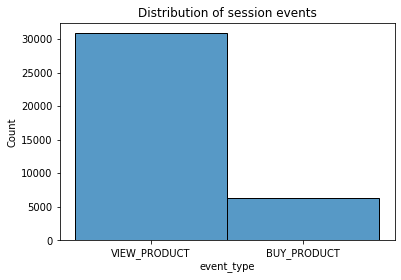

In [38]:
sns.histplot(sessions.event_type)
plt.title("Distribution of session events")
plt.show()

Oba nasze pierwsze modele z Logistic Regression i XGBoost nie biorą tego pod uwagę. Pomimo, że ich dokładność jest bardzo wysoka, to po spojrzeniu w macierz korelacji zauważamy, że przewidują one prawie zawsze tylko brak zakupu i finalnie nie przewyższają skuteczności modelu naiwnego.

## Logistic Regression

In [39]:
y_col = 'event_type_BUY_PRODUCT'

In [40]:
X_train, X_test, y_train, y_test = train_test_split(shop_df[shop_df_check.columns[useful_categories_indices].flatten()], shop_df[y_col], test_size=0.2, random_state=42)

### Niezbalansowany model

In [41]:
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [42]:
model.score(X_test, y_test)

0.838848533763788

In [43]:
f1_score(y_test, y_pred)

0.0

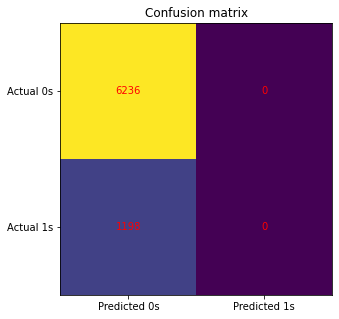

In [44]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

### Zbalansowany model

In [45]:
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0, class_weight='balanced').fit(X_train, y_train)
y_pred = model.predict(X_test)

In [46]:
model.score(X_train, y_train)

0.660366571380528

In [47]:
model.score(X_test, y_test)

0.663303739574926

In [48]:
f1_score(y_test, y_pred)

0.3337769496939047

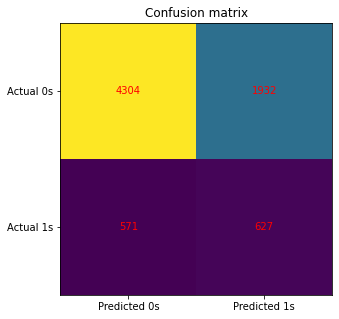

In [49]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

## XGBoost

In [50]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [51]:
X_train, X_test, y_train, y_test = train_test_split(shop_df_xgb, y_xgb, test_size=0.2, random_state=42)

### Niezbalansowany model

In [52]:
threshold = 0.1

model = XGBClassifier()
model.fit(X_train, y_train)

cols_when_model_builds = model.get_booster().feature_names
X_test = X_test[cols_when_model_builds]

# tutaj zmieniłam predict na predict_proba i później predictions z thresholdem
y_pred = model.predict_proba(X_test)
predictions = [1 if value[1]>threshold else 0 for value in y_pred]

f1_score(y_test, predictions)

[21:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.3041736227045075

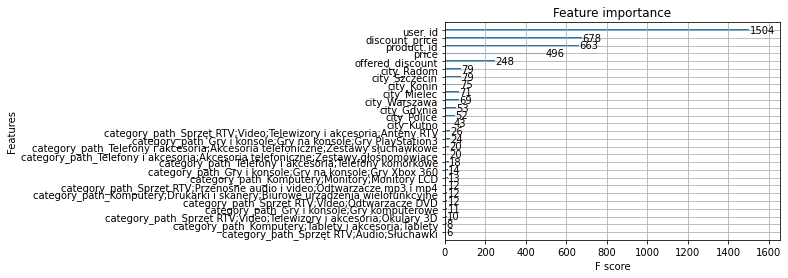

<Figure size 1440x720 with 0 Axes>

In [53]:
plot_importance(model)
plt.figure(figsize = (20, 10))
plt.show()

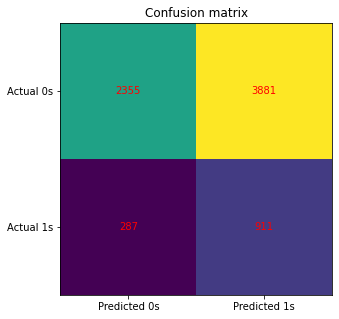

In [54]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

### Zbalansowany model

In [55]:
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

ModuleNotFoundError: No module named 'hyperopt'

In [ ]:
# from sklearn.metrics import average_precision_score

In [ ]:
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha': hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda': hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree': hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 0,
#         'scale_pos_weight' :hp.uniform('scale_pos_weight',0,1)
#     }

In [ ]:
# def objective(space):
#         clf=XGBClassifier(
#                 n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                 reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                 colsample_bytree=int(space['colsample_bytree']), scale_pos_weight=space['scale_pos_weight'])
    
#         evaluation = [( X_train, y_train), ( X_test, y_test)]
    
#         clf.fit(X_train, y_train,
#                 eval_set=evaluation, eval_metric="aucpr",
#                 early_stopping_rounds=10,verbose=False)

#         pred=clf.predict(X_test)
#         y_pred = np.array(list(map(lambda x: int(x), pred>0.5)))
#         f1sc = f1_score(y_test, y_pred)
#         loss = 1 - f1sc
#         return {'loss': loss, 'status' : STATUS_OK}
                
#         # pred = clf.predict(X_test)
#         # accuracy = average_precision_score(y_test, pred)
#         # print ("SCORE:", accuracy)
#         # return {'loss': 1-accuracy, 'status': STATUS_OK }

In [ ]:
# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 50,
#                         trials = trials)

In [ ]:
# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)

In [ ]:
# model = XGBClassifier(parameters=best_hyperparams)
# model.fit(X_train, y_train)

# cols_when_model_builds = model.get_booster().feature_names
# X_test = X_test[cols_when_model_builds]

# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]

# f1_score(y_test, predictions)

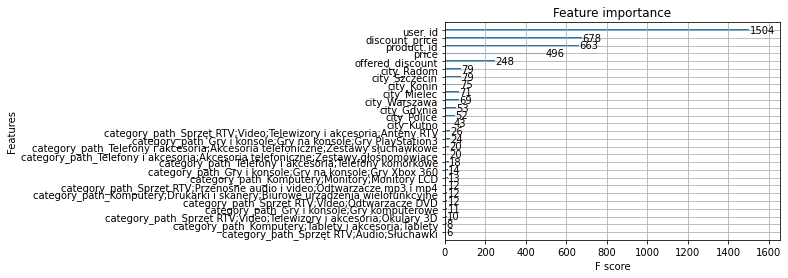

<Figure size 1152x864 with 0 Axes>

In [56]:
plot_importance(model)
plt.figure(figsize = (16, 12))
plt.show()

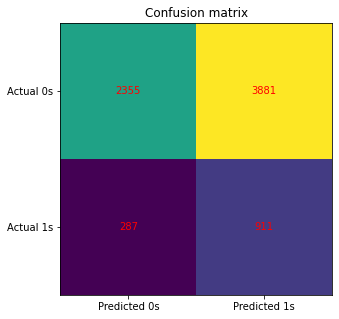

In [57]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

### GridSearchCV do znalezienia odpowiedniej wagi do XGBoost

In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV

# # define grid
# weights = [1, 2, 4, 8, 10, 25, 50]
# param_grid = dict(scale_pos_weight=weights)

# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
# # define grid search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# # execute the grid search
# grid_result = grid.fit(X_train, y_train)

In [81]:
model = XGBClassifier(scale_pos_weight=6)
model.fit(X_train, y_train)

[22:08:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

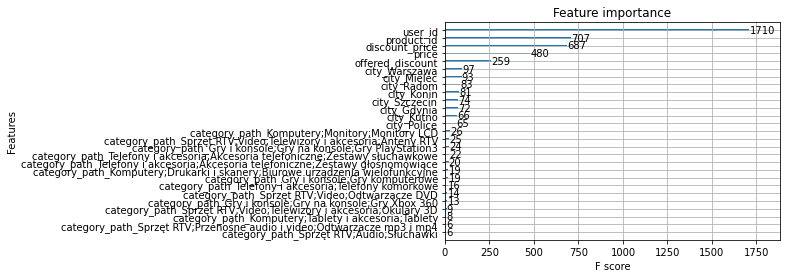

<Figure size 1440x720 with 0 Axes>

In [82]:
plot_importance(model)
plt.figure(figsize = (20, 10))
plt.show()

In [83]:
cols_when_model_builds = model.get_booster().feature_names
X_test = X_test[cols_when_model_builds]

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

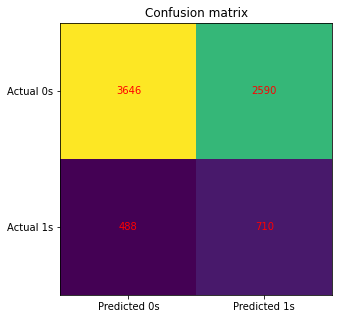

In [84]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

In [85]:
f1_score(y_test, y_pred)

0.3156958648288128

In [89]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

### New research grid

In [104]:
cv_params = {'max_depth': [1,2,4,5,50], 'min_child_weight': [1,2,3,4], 'scale_pos_weight': [2,4,5,6,8], 'reg_lambda':[0.5, 1, 2]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}
grid_cv = GridSearchCV(XGBClassifier(objective='binary:logistic'), cv_params, scoring = 'f1', cv = 5, verbose=10)

In [105]:
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2 
[22:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2, score=0.302, total=   0.2s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2 
[22:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2, score=0.336, total=   0.1s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2 
[22:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2, score=0.282, total=   0.1s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2 
[22:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2, score=0.298, total=   0.1s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2 
[22:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2, score=0.292, total=   0.2s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4 
[22:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4, score=0.384, total=   0.1s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4 
[22:21:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4, score=0.396, total=   0.1s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4 
[22:21:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4, score=0.396, total=   0.2s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4 
[22:21:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4, score=0.398, total=   0.2s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4 
[22:21:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4, score=0.395, total=   0.2s
[CV] max_depth=1, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=5 
[22:21:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child

[CV]  max_depth=1, min_child_weight=1, reg_lambda=1, scale_pos_weight=2, score=0.335, total=   0.1s
[CV] max_depth=1, min_child_weight=1, reg_lambda=1, scale_pos_weight=2 
[22:21:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=1, reg_lambda=1, scale_pos_weight=2, score=0.282, total=   0.2s
[CV] max_depth=1, min_child_weight=1, reg_lambda=1, scale_pos_weight=2 
[22:21:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=

[CV]  max_depth=1, min_child_weight=1, reg_lambda=1, scale_pos_weight=6, score=0.372, total=   0.1s
[CV] max_depth=1, min_child_weight=1, reg_lambda=1, scale_pos_weight=8 
[22:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=1, reg_lambda=1, scale_pos_weight=8, score=0.351, total=   0.1s
[CV] max_depth=1, min_child_weight=1, reg_lambda=1, scale_pos_weight=8 
[22:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=

[22:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=1, reg_lambda=2, scale_pos_weight=5, score=0.402, total=   0.2s
[CV] max_depth=1, min_child_weight=1, reg_lambda=2, scale_pos_weight=5 
[22:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=1, reg_lambda=2, scale_pos_weight=5, score=0.395, total=   0.1s
[CV] max_depth=1, min_child_weight=1, reg_lambda=2, scale_pos_weight=5 
[22:21:09] WARNING: C:/Users/Adminis

[CV]  max_depth=1, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=2, score=0.292, total=   0.1s
[CV] max_depth=1, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=4 
[22:21:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=4, score=0.384, total=   0.2s
[CV] max_depth=1, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=4 
[22:21:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child

[CV]  max_depth=1, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8, score=0.347, total=   0.2s
[CV] max_depth=1, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8 
[22:21:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8, score=0.345, total=   0.1s
[CV] max_depth=1, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8 
[22:21:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child

[CV]  max_depth=1, min_child_weight=2, reg_lambda=1, scale_pos_weight=5, score=0.390, total=   0.2s
[CV] max_depth=1, min_child_weight=2, reg_lambda=1, scale_pos_weight=6 
[22:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=2, reg_lambda=1, scale_pos_weight=6, score=0.367, total=   0.2s
[CV] max_depth=1, min_child_weight=2, reg_lambda=1, scale_pos_weight=6 
[22:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=

[CV]  max_depth=1, min_child_weight=2, reg_lambda=2, scale_pos_weight=4, score=0.396, total=   0.2s
[CV] max_depth=1, min_child_weight=2, reg_lambda=2, scale_pos_weight=4 
[22:21:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=2, reg_lambda=2, scale_pos_weight=4, score=0.396, total=   0.2s
[CV] max_depth=1, min_child_weight=2, reg_lambda=2, scale_pos_weight=4 
[22:21:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=

[CV]  max_depth=1, min_child_weight=2, reg_lambda=2, scale_pos_weight=8, score=0.348, total=   0.1s
[CV] max_depth=1, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=2 
[22:21:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=2, score=0.302, total=   0.1s
[CV] max_depth=1, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=2 
[22:21:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_w

[CV]  max_depth=1, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=6, score=0.367, total=   0.1s
[CV] max_depth=1, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=6 
[22:21:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=6, score=0.367, total=   0.1s
[CV] max_depth=1, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=6 
[22:21:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child

[CV]  max_depth=1, min_child_weight=3, reg_lambda=1, scale_pos_weight=5, score=0.383, total=   0.2s
[CV] max_depth=1, min_child_weight=3, reg_lambda=1, scale_pos_weight=5 
[22:21:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=3, reg_lambda=1, scale_pos_weight=5, score=0.403, total=   0.1s
[CV] max_depth=1, min_child_weight=3, reg_lambda=1, scale_pos_weight=5 
[22:21:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=

[CV]  max_depth=1, min_child_weight=3, reg_lambda=2, scale_pos_weight=2, score=0.298, total=   0.1s
[CV] max_depth=1, min_child_weight=3, reg_lambda=2, scale_pos_weight=2 
[22:21:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=3, reg_lambda=2, scale_pos_weight=2, score=0.296, total=   0.1s
[CV] max_depth=1, min_child_weight=3, reg_lambda=2, scale_pos_weight=4 
[22:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=

[CV]  max_depth=1, min_child_weight=3, reg_lambda=2, scale_pos_weight=8, score=0.360, total=   0.1s
[CV] max_depth=1, min_child_weight=3, reg_lambda=2, scale_pos_weight=8 
[22:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=3, reg_lambda=2, scale_pos_weight=8, score=0.347, total=   0.1s
[CV] max_depth=1, min_child_weight=3, reg_lambda=2, scale_pos_weight=8 
[22:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=

[22:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=5, score=0.392, total=   0.1s
[CV] max_depth=1, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=5 
[22:21:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=5, score=0.390, total=   0.2s
[CV] max_depth=1, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=6 
[22:21:36] WARNING: C:/Users

[22:21:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=4, reg_lambda=1, scale_pos_weight=4, score=0.384, total=   0.2s
[CV] max_depth=1, min_child_weight=4, reg_lambda=1, scale_pos_weight=4 
[22:21:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=4, reg_lambda=1, scale_pos_weight=4, score=0.396, total=   0.1s
[CV] max_depth=1, min_child_weight=4, reg_lambda=1, scale_pos_weight=4 
[22:21:38] WARNING: C:/Users/Adminis

[CV]  max_depth=1, min_child_weight=4, reg_lambda=1, scale_pos_weight=8, score=0.345, total=   0.1s
[CV] max_depth=1, min_child_weight=4, reg_lambda=1, scale_pos_weight=8 
[22:21:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=4, reg_lambda=1, scale_pos_weight=8, score=0.348, total=   0.1s
[CV] max_depth=1, min_child_weight=4, reg_lambda=2, scale_pos_weight=2 
[22:21:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=

[CV]  max_depth=1, min_child_weight=4, reg_lambda=2, scale_pos_weight=6, score=0.364, total=   0.1s
[CV] max_depth=1, min_child_weight=4, reg_lambda=2, scale_pos_weight=6 
[22:21:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=4, reg_lambda=2, scale_pos_weight=6, score=0.367, total=   0.1s
[CV] max_depth=1, min_child_weight=4, reg_lambda=2, scale_pos_weight=6 
[22:21:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=1, min_child_weight=

[CV]  max_depth=2, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4, score=0.393, total=   0.2s
[CV] max_depth=2, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4 
[22:21:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4, score=0.382, total=   0.2s
[CV] max_depth=2, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=5 
[22:21:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child

[CV] max_depth=2, min_child_weight=1, reg_lambda=1, scale_pos_weight=2 
[22:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=1, reg_lambda=1, scale_pos_weight=2, score=0.325, total=   0.2s
[CV] max_depth=2, min_child_weight=1, reg_lambda=1, scale_pos_weight=2 
[22:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=1, reg_lambda=1, scale_pos_weight=2, score=0.303, total=   0.2s
[CV] max_depth=2, min_child_weight=1

[CV]  max_depth=2, min_child_weight=1, reg_lambda=1, scale_pos_weight=6, score=0.370, total=   0.2s
[CV] max_depth=2, min_child_weight=1, reg_lambda=1, scale_pos_weight=6 
[22:21:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=1, reg_lambda=1, scale_pos_weight=6, score=0.367, total=   0.2s
[CV] max_depth=2, min_child_weight=1, reg_lambda=1, scale_pos_weight=8 
[22:21:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=1, reg_lambda=2, scale_pos_weight=5, score=0.381, total=   0.2s
[CV] max_depth=2, min_child_weight=1, reg_lambda=2, scale_pos_weight=5 
[22:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=1, reg_lambda=2, scale_pos_weight=5, score=0.392, total=   0.2s
[CV] max_depth=2, min_child_weight=1, reg_lambda=2, scale_pos_weight=5 
[22:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=2, score=0.296, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=2 
[22:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=2, score=0.307, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=2 
[22:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child

[CV]  max_depth=2, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=6, score=0.363, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8 
[22:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8, score=0.347, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8 
[22:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child

[CV]  max_depth=2, min_child_weight=2, reg_lambda=1, scale_pos_weight=5, score=0.389, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=1, scale_pos_weight=5 
[22:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=2, reg_lambda=1, scale_pos_weight=5, score=0.389, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=1, scale_pos_weight=5 
[22:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=2, reg_lambda=2, scale_pos_weight=2, score=0.312, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=2, scale_pos_weight=2 
[22:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=2, reg_lambda=2, scale_pos_weight=2, score=0.305, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=2, scale_pos_weight=4 
[22:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=2, reg_lambda=2, scale_pos_weight=8, score=0.348, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=2, scale_pos_weight=8 
[22:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=2, reg_lambda=2, scale_pos_weight=8, score=0.353, total=   0.2s
[CV] max_depth=2, min_child_weight=2, reg_lambda=2, scale_pos_weight=8 
[22:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=5, score=0.387, total=   0.2s
[CV] max_depth=2, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=5 
[22:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=5, score=0.384, total=   0.2s
[CV] max_depth=2, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=5 
[22:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child

[CV]  max_depth=2, min_child_weight=3, reg_lambda=1, scale_pos_weight=2, score=0.300, total=   0.2s
[CV] max_depth=2, min_child_weight=3, reg_lambda=1, scale_pos_weight=4 
[22:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=3, reg_lambda=1, scale_pos_weight=4, score=0.381, total=   0.2s
[CV] max_depth=2, min_child_weight=3, reg_lambda=1, scale_pos_weight=4 
[22:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=3, reg_lambda=1, scale_pos_weight=8, score=0.352, total=   0.2s
[CV] max_depth=2, min_child_weight=3, reg_lambda=1, scale_pos_weight=8 
[22:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=3, reg_lambda=1, scale_pos_weight=8, score=0.344, total=   0.2s
[CV] max_depth=2, min_child_weight=3, reg_lambda=1, scale_pos_weight=8 
[22:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=3, reg_lambda=2, scale_pos_weight=5, score=0.384, total=   0.2s
[CV] max_depth=2, min_child_weight=3, reg_lambda=2, scale_pos_weight=5 
[22:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=3, reg_lambda=2, scale_pos_weight=5, score=0.390, total=   0.2s
[CV] max_depth=2, min_child_weight=3, reg_lambda=2, scale_pos_weight=6 
[22:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=4, score=0.379, total=   0.2s
[CV] max_depth=2, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=4 
[22:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=4, score=0.399, total=   0.2s
[CV] max_depth=2, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=4 
[22:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child

[CV]  max_depth=2, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=8, score=0.344, total=   0.2s
[CV] max_depth=2, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=8 
[22:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=8, score=0.349, total=   0.2s
[CV] max_depth=2, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=8 
[22:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child

[CV]  max_depth=2, min_child_weight=4, reg_lambda=1, scale_pos_weight=5, score=0.389, total=   0.2s
[CV] max_depth=2, min_child_weight=4, reg_lambda=1, scale_pos_weight=6 
[22:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=4, reg_lambda=1, scale_pos_weight=6, score=0.371, total=   0.2s
[CV] max_depth=2, min_child_weight=4, reg_lambda=1, scale_pos_weight=6 
[22:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=4, reg_lambda=2, scale_pos_weight=4, score=0.399, total=   0.2s
[CV] max_depth=2, min_child_weight=4, reg_lambda=2, scale_pos_weight=4 
[22:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=4, reg_lambda=2, scale_pos_weight=4, score=0.391, total=   0.2s
[CV] max_depth=2, min_child_weight=4, reg_lambda=2, scale_pos_weight=4 
[22:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=

[CV]  max_depth=2, min_child_weight=4, reg_lambda=2, scale_pos_weight=8, score=0.351, total=   0.2s
[CV] max_depth=2, min_child_weight=4, reg_lambda=2, scale_pos_weight=8 
[22:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=2, min_child_weight=4, reg_lambda=2, scale_pos_weight=8, score=0.349, total=   0.2s
[CV] max_depth=4, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2 
[22:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weigh

[CV]  max_depth=4, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=6, score=0.341, total=   0.3s
[CV] max_depth=4, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=6 
[22:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=6, score=0.354, total=   0.3s
[CV] max_depth=4, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=6 
[22:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child

[CV]  max_depth=4, min_child_weight=1, reg_lambda=1, scale_pos_weight=4, score=0.362, total=   0.3s
[CV] max_depth=4, min_child_weight=1, reg_lambda=1, scale_pos_weight=4 
[22:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=1, reg_lambda=1, scale_pos_weight=4, score=0.356, total=   0.3s
[CV] max_depth=4, min_child_weight=1, reg_lambda=1, scale_pos_weight=4 
[22:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=1, reg_lambda=1, scale_pos_weight=8, score=0.335, total=   0.3s
[CV] max_depth=4, min_child_weight=1, reg_lambda=2, scale_pos_weight=2 
[22:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=1, reg_lambda=2, scale_pos_weight=2, score=0.277, total=   0.3s
[CV] max_depth=4, min_child_weight=1, reg_lambda=2, scale_pos_weight=2 
[22:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=1, reg_lambda=2, scale_pos_weight=6, score=0.359, total=   0.3s
[CV] max_depth=4, min_child_weight=1, reg_lambda=2, scale_pos_weight=6 
[22:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=1, reg_lambda=2, scale_pos_weight=6, score=0.351, total=   0.3s
[CV] max_depth=4, min_child_weight=1, reg_lambda=2, scale_pos_weight=6 
[22:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=4, score=0.362, total=   0.3s
[CV] max_depth=4, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=4 
[22:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=4, score=0.365, total=   0.3s
[CV] max_depth=4, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=5 
[22:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child

[CV]  max_depth=4, min_child_weight=2, reg_lambda=1, scale_pos_weight=2, score=0.276, total=   0.3s
[CV] max_depth=4, min_child_weight=2, reg_lambda=1, scale_pos_weight=2 
[22:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=2, reg_lambda=1, scale_pos_weight=2, score=0.284, total=   0.3s
[CV] max_depth=4, min_child_weight=2, reg_lambda=1, scale_pos_weight=2 
[22:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=2, reg_lambda=1, scale_pos_weight=6, score=0.350, total=   0.3s
[CV] max_depth=4, min_child_weight=2, reg_lambda=1, scale_pos_weight=6 
[22:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=2, reg_lambda=1, scale_pos_weight=6, score=0.354, total=   0.3s
[CV] max_depth=4, min_child_weight=2, reg_lambda=1, scale_pos_weight=6 
[22:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=2, reg_lambda=2, scale_pos_weight=4, score=0.368, total=   0.3s
[CV] max_depth=4, min_child_weight=2, reg_lambda=2, scale_pos_weight=5 
[22:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=2, reg_lambda=2, scale_pos_weight=5, score=0.353, total=   0.3s
[CV] max_depth=4, min_child_weight=2, reg_lambda=2, scale_pos_weight=5 
[22:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=2, score=0.279, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=2 
[22:23:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=2, score=0.269, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=2 
[22:23:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child

[CV]  max_depth=4, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=6, score=0.353, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=6 
[22:23:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=6, score=0.353, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=8 
[22:23:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child

[CV]  max_depth=4, min_child_weight=3, reg_lambda=1, scale_pos_weight=5, score=0.352, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=1, scale_pos_weight=5 
[22:23:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=3, reg_lambda=1, scale_pos_weight=5, score=0.368, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=1, scale_pos_weight=5 
[22:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=3, reg_lambda=2, scale_pos_weight=2, score=0.285, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=2, scale_pos_weight=2 
[22:23:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=3, reg_lambda=2, scale_pos_weight=2, score=0.278, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=2, scale_pos_weight=2 
[22:23:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=3, reg_lambda=2, scale_pos_weight=6, score=0.362, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=2, scale_pos_weight=8 
[22:23:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=3, reg_lambda=2, scale_pos_weight=8, score=0.333, total=   0.3s
[CV] max_depth=4, min_child_weight=3, reg_lambda=2, scale_pos_weight=8 
[22:23:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=5, score=0.362, total=   0.3s
[CV] max_depth=4, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=5 
[22:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=5, score=0.357, total=   0.3s
[CV] max_depth=4, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=5 
[22:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child

[CV]  max_depth=4, min_child_weight=4, reg_lambda=1, scale_pos_weight=2, score=0.274, total=   0.3s
[CV] max_depth=4, min_child_weight=4, reg_lambda=1, scale_pos_weight=2 
[22:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=4, reg_lambda=1, scale_pos_weight=2, score=0.279, total=   0.3s
[CV] max_depth=4, min_child_weight=4, reg_lambda=1, scale_pos_weight=4 
[22:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=4, reg_lambda=1, scale_pos_weight=8, score=0.331, total=   0.3s
[CV] max_depth=4, min_child_weight=4, reg_lambda=1, scale_pos_weight=8 
[22:24:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=4, reg_lambda=1, scale_pos_weight=8, score=0.332, total=   0.3s
[CV] max_depth=4, min_child_weight=4, reg_lambda=1, scale_pos_weight=8 
[22:24:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=4, min_child_weight=4, reg_lambda=2, scale_pos_weight=5, score=0.351, total=   0.3s
[CV] max_depth=4, min_child_weight=4, reg_lambda=2, scale_pos_weight=5 
[22:24:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=4, reg_lambda=2, scale_pos_weight=5, score=0.366, total=   0.3s
[CV] max_depth=4, min_child_weight=4, reg_lambda=2, scale_pos_weight=5 
[22:24:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=4, min_child_weight=

[CV]  max_depth=5, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=2, score=0.264, total=   0.4s
[CV] max_depth=5, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4 
[22:24:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4, score=0.330, total=   0.4s
[CV] max_depth=5, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=4 
[22:24:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child

[CV]  max_depth=5, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=8, score=0.325, total=   0.4s
[CV] max_depth=5, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=8 
[22:24:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=8, score=0.320, total=   0.4s
[CV] max_depth=5, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=8 
[22:24:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child

[CV]  max_depth=5, min_child_weight=1, reg_lambda=1, scale_pos_weight=5, score=0.343, total=   0.4s
[CV] max_depth=5, min_child_weight=1, reg_lambda=1, scale_pos_weight=5 
[22:24:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=1, reg_lambda=1, scale_pos_weight=5, score=0.346, total=   0.3s
[CV] max_depth=5, min_child_weight=1, reg_lambda=1, scale_pos_weight=6 
[22:24:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=1, reg_lambda=2, scale_pos_weight=4, score=0.339, total=   0.4s
[CV] max_depth=5, min_child_weight=1, reg_lambda=2, scale_pos_weight=4 
[22:24:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=1, reg_lambda=2, scale_pos_weight=4, score=0.350, total=   0.4s
[CV] max_depth=5, min_child_weight=1, reg_lambda=2, scale_pos_weight=4 
[22:24:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=1, reg_lambda=2, scale_pos_weight=8, score=0.321, total=   0.4s
[CV] max_depth=5, min_child_weight=1, reg_lambda=2, scale_pos_weight=8 
[22:24:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=1, reg_lambda=2, scale_pos_weight=8, score=0.331, total=   0.4s
[CV] max_depth=5, min_child_weight=1, reg_lambda=2, scale_pos_weight=8 
[22:24:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=5, score=0.355, total=   0.4s
[CV] max_depth=5, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=6 
[22:24:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=6, score=0.321, total=   0.4s
[CV] max_depth=5, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=6 
[22:24:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child

[CV]  max_depth=5, min_child_weight=2, reg_lambda=1, scale_pos_weight=4, score=0.351, total=   0.3s
[CV] max_depth=5, min_child_weight=2, reg_lambda=1, scale_pos_weight=4 
[22:24:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=2, reg_lambda=1, scale_pos_weight=4, score=0.335, total=   0.4s
[CV] max_depth=5, min_child_weight=2, reg_lambda=1, scale_pos_weight=4 
[22:24:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=2, reg_lambda=1, scale_pos_weight=8, score=0.328, total=   0.4s
[CV] max_depth=5, min_child_weight=2, reg_lambda=1, scale_pos_weight=8 
[22:25:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=2, reg_lambda=1, scale_pos_weight=8, score=0.337, total=   0.4s
[CV] max_depth=5, min_child_weight=2, reg_lambda=2, scale_pos_weight=2 
[22:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=2, reg_lambda=2, scale_pos_weight=6, score=0.329, total=   0.4s
[CV] max_depth=5, min_child_weight=2, reg_lambda=2, scale_pos_weight=6 
[22:25:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=2, reg_lambda=2, scale_pos_weight=6, score=0.346, total=   0.4s
[CV] max_depth=5, min_child_weight=2, reg_lambda=2, scale_pos_weight=6 
[22:25:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=4, score=0.332, total=   0.4s
[CV] max_depth=5, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=4 
[22:25:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=4, score=0.336, total=   0.4s
[CV] max_depth=5, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=4 
[22:25:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child

[CV]  max_depth=5, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=8, score=0.330, total=   0.4s
[CV] max_depth=5, min_child_weight=3, reg_lambda=1, scale_pos_weight=2 
[22:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=3, reg_lambda=1, scale_pos_weight=2, score=0.252, total=   0.4s
[CV] max_depth=5, min_child_weight=3, reg_lambda=1, scale_pos_weight=2 
[22:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weigh

[CV]  max_depth=5, min_child_weight=3, reg_lambda=1, scale_pos_weight=6, score=0.347, total=   0.4s
[CV] max_depth=5, min_child_weight=3, reg_lambda=1, scale_pos_weight=6 
[22:25:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=3, reg_lambda=1, scale_pos_weight=6, score=0.331, total=   0.4s
[CV] max_depth=5, min_child_weight=3, reg_lambda=1, scale_pos_weight=6 
[22:25:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=3, reg_lambda=2, scale_pos_weight=4, score=0.349, total=   0.4s
[CV] max_depth=5, min_child_weight=3, reg_lambda=2, scale_pos_weight=4 
[22:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=3, reg_lambda=2, scale_pos_weight=4, score=0.345, total=   0.4s
[CV] max_depth=5, min_child_weight=3, reg_lambda=2, scale_pos_weight=5 
[22:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=2, score=0.259, total=   0.4s
[CV] max_depth=5, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=2 
[22:25:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=2, score=0.262, total=   0.3s
[CV] max_depth=5, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=2 
[22:25:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child

[CV]  max_depth=5, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=6, score=0.326, total=   0.4s
[CV] max_depth=5, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=6 
[22:25:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=6, score=0.338, total=   0.4s
[CV] max_depth=5, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=6 
[22:25:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child

[CV]  max_depth=5, min_child_weight=4, reg_lambda=1, scale_pos_weight=4, score=0.348, total=   0.4s
[CV] max_depth=5, min_child_weight=4, reg_lambda=1, scale_pos_weight=5 
[22:25:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=4, reg_lambda=1, scale_pos_weight=5, score=0.338, total=   0.4s
[CV] max_depth=5, min_child_weight=4, reg_lambda=1, scale_pos_weight=5 
[22:25:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=4, reg_lambda=2, scale_pos_weight=2, score=0.261, total=   0.3s
[CV] max_depth=5, min_child_weight=4, reg_lambda=2, scale_pos_weight=2 
[22:25:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=4, reg_lambda=2, scale_pos_weight=2, score=0.261, total=   0.3s
[CV] max_depth=5, min_child_weight=4, reg_lambda=2, scale_pos_weight=2 
[22:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=5, min_child_weight=4, reg_lambda=2, scale_pos_weight=6, score=0.344, total=   0.4s
[CV] max_depth=5, min_child_weight=4, reg_lambda=2, scale_pos_weight=6 
[22:26:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=4, reg_lambda=2, scale_pos_weight=6, score=0.345, total=   0.4s
[CV] max_depth=5, min_child_weight=4, reg_lambda=2, scale_pos_weight=8 
[22:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=5, min_child_weight=

[CV]  max_depth=50, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=5, score=0.187, total=   4.2s
[CV] max_depth=50, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=5 
[22:26:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=5, score=0.195, total=   4.2s
[CV] max_depth=50, min_child_weight=1, reg_lambda=0.5, scale_pos_weight=5 
[22:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_

[CV]  max_depth=50, min_child_weight=1, reg_lambda=1, scale_pos_weight=2, score=0.121, total=   3.9s
[CV] max_depth=50, min_child_weight=1, reg_lambda=1, scale_pos_weight=2 
[22:28:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=1, reg_lambda=1, scale_pos_weight=2, score=0.135, total=   4.1s
[CV] max_depth=50, min_child_weight=1, reg_lambda=1, scale_pos_weight=2 
[22:28:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=1, reg_lambda=1, scale_pos_weight=6, score=0.188, total=   4.2s
[CV] max_depth=50, min_child_weight=1, reg_lambda=1, scale_pos_weight=8 
[22:29:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=1, reg_lambda=1, scale_pos_weight=8, score=0.190, total=   4.3s
[CV] max_depth=50, min_child_weight=1, reg_lambda=1, scale_pos_weight=8 
[22:29:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=1, reg_lambda=2, scale_pos_weight=5, score=0.193, total=   4.6s
[CV] max_depth=50, min_child_weight=1, reg_lambda=2, scale_pos_weight=5 
[22:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=1, reg_lambda=2, scale_pos_weight=5, score=0.186, total=   4.6s
[CV] max_depth=50, min_child_weight=1, reg_lambda=2, scale_pos_weight=5 
[22:30:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=2, score=0.136, total=   3.6s
[CV] max_depth=50, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=2 
[22:31:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=2, score=0.118, total=   3.7s
[CV] max_depth=50, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=4 
[22:31:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_

[CV]  max_depth=50, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8, score=0.193, total=   3.6s
[CV] max_depth=50, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8 
[22:32:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8, score=0.194, total=   3.6s
[CV] max_depth=50, min_child_weight=2, reg_lambda=0.5, scale_pos_weight=8 
[22:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_

[CV]  max_depth=50, min_child_weight=2, reg_lambda=1, scale_pos_weight=5, score=0.187, total=   3.5s
[CV] max_depth=50, min_child_weight=2, reg_lambda=1, scale_pos_weight=5 
[22:33:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=2, reg_lambda=1, scale_pos_weight=5, score=0.192, total=   3.4s
[CV] max_depth=50, min_child_weight=2, reg_lambda=1, scale_pos_weight=5 
[22:33:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=2, reg_lambda=2, scale_pos_weight=2, score=0.121, total=   3.0s
[CV] max_depth=50, min_child_weight=2, reg_lambda=2, scale_pos_weight=4 
[22:34:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=2, reg_lambda=2, scale_pos_weight=4, score=0.182, total=   3.4s
[CV] max_depth=50, min_child_weight=2, reg_lambda=2, scale_pos_weight=4 
[22:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=2, reg_lambda=2, scale_pos_weight=8, score=0.196, total=   3.6s
[CV] max_depth=50, min_child_weight=2, reg_lambda=2, scale_pos_weight=8 
[22:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=2, reg_lambda=2, scale_pos_weight=8, score=0.192, total=   3.6s
[CV] max_depth=50, min_child_weight=2, reg_lambda=2, scale_pos_weight=8 
[22:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=5, score=0.196, total=   3.1s
[CV] max_depth=50, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=5 
[22:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=5, score=0.186, total=   3.2s
[CV] max_depth=50, min_child_weight=3, reg_lambda=0.5, scale_pos_weight=6 
[22:36:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_

[CV]  max_depth=50, min_child_weight=3, reg_lambda=1, scale_pos_weight=4, score=0.181, total=   3.1s
[CV] max_depth=50, min_child_weight=3, reg_lambda=1, scale_pos_weight=4 
[22:37:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=3, reg_lambda=1, scale_pos_weight=4, score=0.181, total=   3.1s
[CV] max_depth=50, min_child_weight=3, reg_lambda=1, scale_pos_weight=4 
[22:37:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=3, reg_lambda=1, scale_pos_weight=8, score=0.194, total=   3.3s
[CV] max_depth=50, min_child_weight=3, reg_lambda=1, scale_pos_weight=8 
[22:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=3, reg_lambda=1, scale_pos_weight=8, score=0.200, total=   3.2s
[CV] max_depth=50, min_child_weight=3, reg_lambda=1, scale_pos_weight=8 
[22:38:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=3, reg_lambda=2, scale_pos_weight=5, score=0.186, total=   3.1s
[CV] max_depth=50, min_child_weight=3, reg_lambda=2, scale_pos_weight=6 
[22:39:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=3, reg_lambda=2, scale_pos_weight=6, score=0.192, total=   3.2s
[CV] max_depth=50, min_child_weight=3, reg_lambda=2, scale_pos_weight=6 
[22:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=4, score=0.183, total=   3.1s
[CV] max_depth=50, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=4 
[22:39:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=4, score=0.184, total=   2.9s
[CV] max_depth=50, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=4 
[22:40:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_

[CV]  max_depth=50, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=8, score=0.197, total=   3.1s
[CV] max_depth=50, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=8 
[22:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=4, reg_lambda=0.5, scale_pos_weight=8, score=0.194, total=   3.1s
[CV] max_depth=50, min_child_weight=4, reg_lambda=1, scale_pos_weight=2 
[22:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_ch

[CV]  max_depth=50, min_child_weight=4, reg_lambda=1, scale_pos_weight=6, score=0.193, total=   3.0s
[CV] max_depth=50, min_child_weight=4, reg_lambda=1, scale_pos_weight=6 
[22:41:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=4, reg_lambda=1, scale_pos_weight=6, score=0.194, total=   3.3s
[CV] max_depth=50, min_child_weight=4, reg_lambda=1, scale_pos_weight=6 
[22:41:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=4, reg_lambda=2, scale_pos_weight=4, score=0.185, total=   2.9s
[CV] max_depth=50, min_child_weight=4, reg_lambda=2, scale_pos_weight=4 
[22:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_weight=4, reg_lambda=2, scale_pos_weight=4, score=0.192, total=   2.9s
[CV] max_depth=50, min_child_weight=4, reg_lambda=2, scale_pos_weight=4 
[22:42:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  max_depth=50, min_child_we

[CV]  max_depth=50, min_child_weight=4, reg_lambda=2, scale_pos_weight=8, score=0.194, total=   3.1s
[22:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 22.3min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [106]:
grid_cv.best_params_

{'max_depth': 1, 'min_child_weight': 1, 'reg_lambda': 1, 'scale_pos_weight': 4}

In [107]:
grid_cv.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
            

In [108]:
# model = XGBClassifier(params=grid_cv.best_params_)
# model.fit(X_train, y_train)

In [110]:
# cols_when_model_builds = grid_cv.get_booster().feature_names
# X_test = X_test[cols_when_model_builds]

y_pred = grid_cv.predict(X_test)
predictions = [round(value) for value in y_pred]

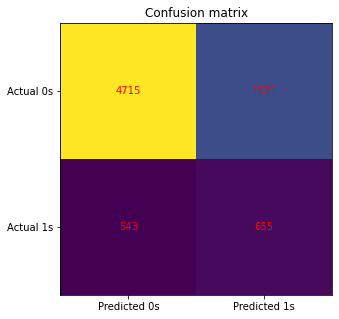

In [111]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title('Confusion matrix')
plt.show()

In [112]:
f1_score(y_test, y_pred)

0.3882631890930646

### Save model

In [116]:
import pickle

with open('model/grid_sessions.pkl', 'wb') as model_file:
    pickle.dump(grid_cv, model_file)

In [129]:
UPLOAD_FOLDER = r'C:\Users\Bindas\PycharmProjects\flaskProject\uploads'

with open(f'model/grid_sessions.pkl', 'rb') as f:
    model = pickle.load(f)

products = pd.read_json(os.path.join(UPLOAD_FOLDER, "products.jsonl"), lines=True)
sessions = pd.read_json(os.path.join(UPLOAD_FOLDER, "sessions.jsonl"), lines=True)
users = pd.read_json(os.path.join(UPLOAD_FOLDER, "users.jsonl"), lines=True)

shop_df = sessions.merge(products, on="product_id", how="left")
shop_df = shop_df.merge(users, on='user_id', how='left')

shop_df["discount_price"] = (shop_df["price"] * shop_df["offered_discount"])

shop_df = shop_df[shop_df.columns[~shop_df.columns.isin(["product_name", "purchase_id", "name", "street", "timestamp", "purchase_id_isnan"])]]
shop_df = pd.get_dummies(shop_df)

X = shop_df[shop_df.columns[~shop_df.columns.isin(
    ["event_type_BUY_PRODUCT", "event_type_VIEW_PRODUCT", "purchase_id_isnan", "timestamp"])]]

session_ids = X["session_id"]
X = X.drop('session_id', 1)

flag = np.where(np.array(model.predict_proba(X))[:, 1] > 0.45, True, False)
results = X[flag]
select_columns = ["user_id", "product_id", "offered_discount", "price"]
results = results[select_columns]
results = pd.merge(session_ids, results, left_index=True, right_index=True, how="inner").drop_duplicates()

In [130]:
results

,session_id,user_id,product_id,offered_discount,price
0,100001,102,1281,0,64.80
1,100001,102,1278,0,78.90
3,100002,102,1278,0,78.90
5,100003,102,1276,0,1816.97
7,100004,102,1001,0,58.97
...,...,...,...,...,...
37146,109831,301,1276,0,1816.97
37147,109831,301,1277,0,2317.02
37149,109833,301,1277,0,2317.02
37150,109834,301,1067,0,207.33


In [128]:
sessions.head(20)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2021-02-09 13:37:03,102,1281,VIEW_PRODUCT,0,NaN
1,100001,2021-02-09 13:39:40,102,1278,VIEW_PRODUCT,0,NaN
2,100001,2021-02-09 13:40:37,102,1278,BUY_PRODUCT,0,20001.0
3,100002,2020-06-28 17:55:13,102,1278,VIEW_PRODUCT,0,NaN
4,100002,2020-06-28 17:55:46,102,1278,BUY_PRODUCT,0,20002.0
5,100003,2020-12-27 06:27:02,102,1276,VIEW_PRODUCT,0,NaN
6,100003,2020-12-27 06:31:55,102,1276,BUY_PRODUCT,0,20003.0
7,100004,2021-02-13 01:14:18,102,1001,VIEW_PRODUCT,0,NaN
8,100005,2020-12-26 15:28:55,102,1319,VIEW_PRODUCT,0,NaN
9,100005,2020-12-26 15:29:27,102,1319,BUY_PRODUCT,0,20004.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=66e1533a-74fd-4fb4-a4df-ef459a71b06f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>